In [158]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ModuleNotFoundError: No module named 'xgboost'

# Load Dataset

In [123]:
df1 = pd.read_csv("tc20171021.csv", error_bad_lines=False, warn_bad_lines=False)
df2 = pd.read_csv("true_car_listings.csv", error_bad_lines=False, warn_bad_lines=False)

In [124]:
df1.head()

,Id,Price,Year,Mileage,City,State,Vin,Make,Model
0,1,16472,2015,18681,Jefferson City,MO,KL4CJBSBXFB267643,Buick,EncoreConvenience
1,2,15749,2015,27592,Highland,IN,KL4CJASB5FB245057,Buick,EncoreFWD
2,3,16998,2015,13650,Boone,NC,KL4CJCSB0FB264921,Buick,EncoreLeather
3,4,15777,2015,25195,New Orleans,LA,KL4CJASB4FB217542,Buick,EncoreFWD
4,5,16784,2015,22800,Las Vegas,NV,KL4CJBSB3FB166881,Buick,EncoreConvenience


In [125]:
df2.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


# Data Cleaning

## Combine Datasets

In [126]:
df1.drop("Id", axis=1, inplace=True)

In [127]:
df= pd.concat([df1, df2])
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,16472,2015,18681,Jefferson City,MO,KL4CJBSBXFB267643,Buick,EncoreConvenience
1,15749,2015,27592,Highland,IN,KL4CJASB5FB245057,Buick,EncoreFWD
2,16998,2015,13650,Boone,NC,KL4CJCSB0FB264921,Buick,EncoreLeather
3,15777,2015,25195,New Orleans,LA,KL4CJASB4FB217542,Buick,EncoreFWD
4,16784,2015,22800,Las Vegas,NV,KL4CJBSB3FB166881,Buick,EncoreConvenience


## Remove Outliers

In [140]:
df = df.loc[df["Mileage"]<= 300000]
df = df.loc[df["Price"] <= 150000]

## Drop useless columns

In [129]:
df.drop("Vin", axis=1, inplace=True)

# EDA

In [108]:
df.describe()

,Price,Year,Mileage
count,2.067535e+06,2.067535e+06,2.067535e+06
mean,2.117696e+04,2.013303e+03,5.254407e+04
std,1.334299e+04,3.426571e+00,4.080885e+04
min,1.500000e+03,1.997000e+03,5.000000e+00
25%,1.299500e+04,2.012000e+03,2.390300e+04
50%,1.800000e+04,2.014000e+03,4.040900e+04
75%,2.683000e+04,2.016000e+03,7.244500e+04
max,4.995000e+05,2.018000e+03,3.000000e+05


In [109]:
df.isnull().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Make       0
Model      0
dtype: int64

<AxesSubplot:title={'center':'Distribution of Mileage'}, xlabel='Mileage'>

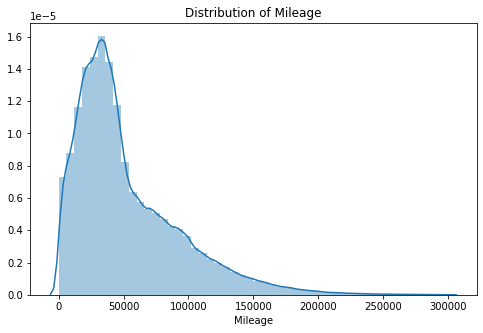

In [141]:
plt.figure(figsize = (8,5))
plt.title("Distribution of Mileage")
sns.distplot(df["Mileage"])

<AxesSubplot:title={'center':'Distribution of Price'}, xlabel='Price'>

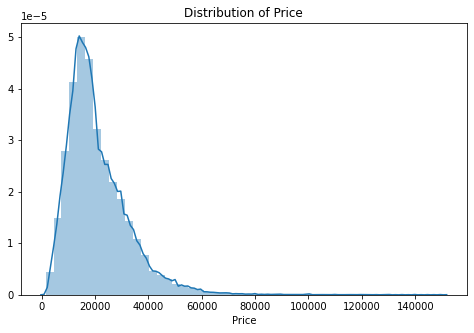

In [142]:
plt.figure(figsize=(8,5))
plt.title("Distribution of Price")
sns.distplot(df["Price"])

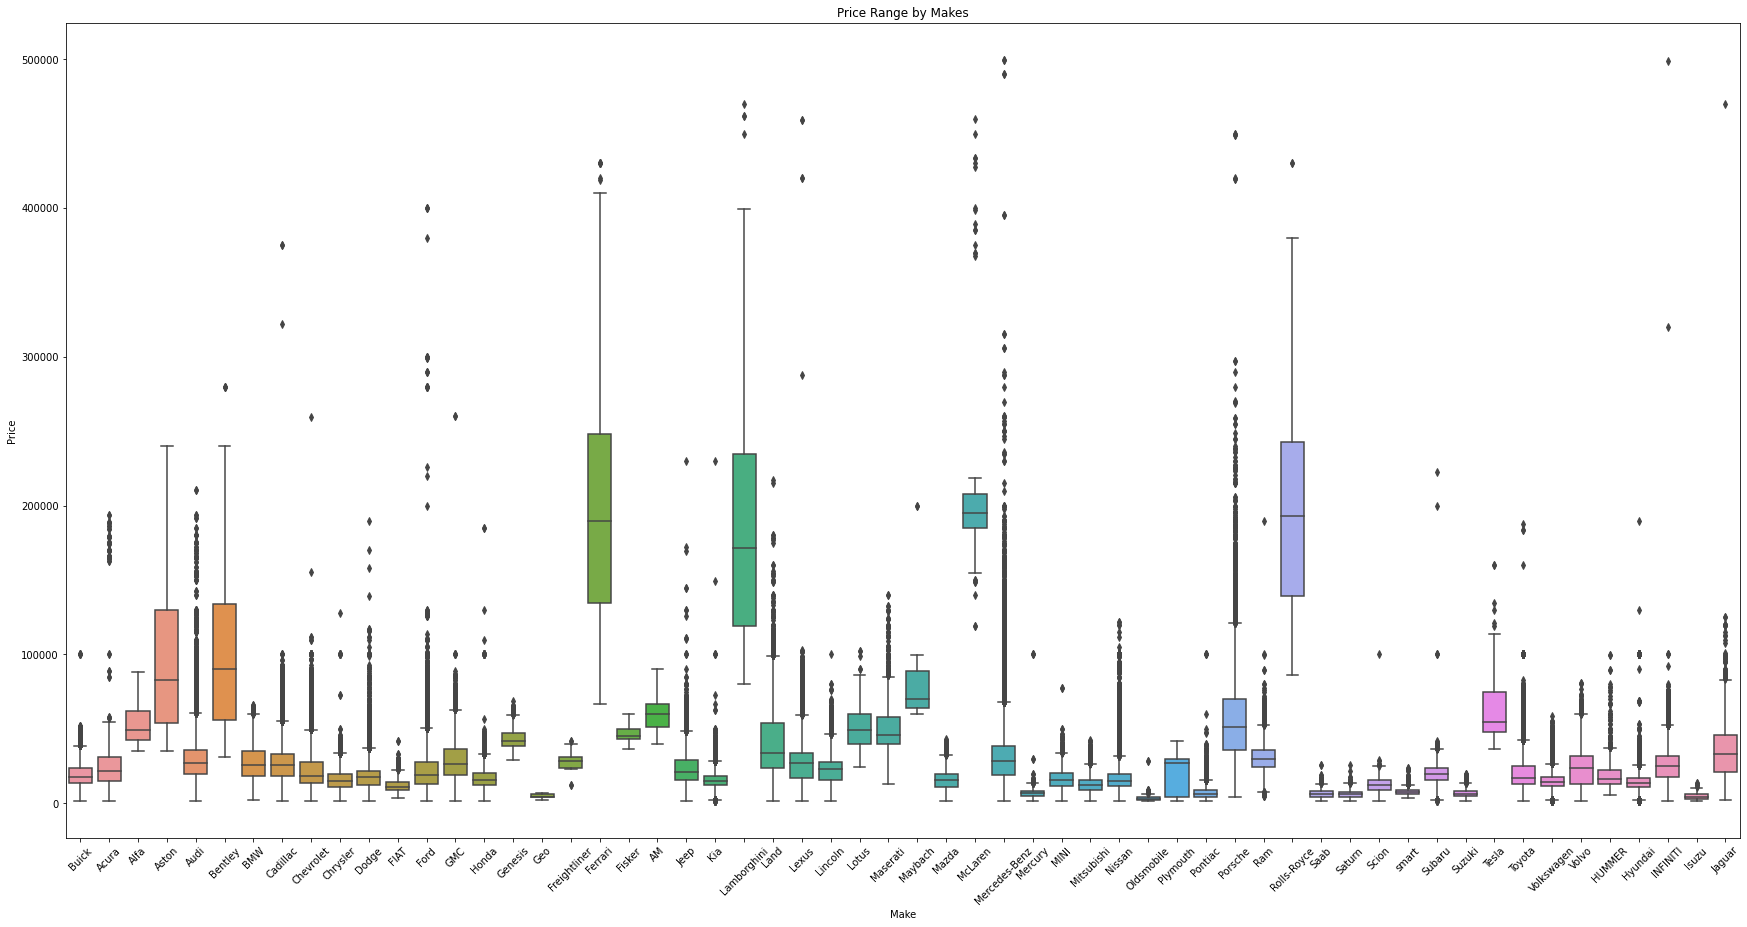

In [110]:
plt.figure(figsize=(30,15))
plt.title("Price Range by Makes")
ax = sns.boxplot(x="Make", y="Price", data=df)
t = plt.xticks(rotation=45)

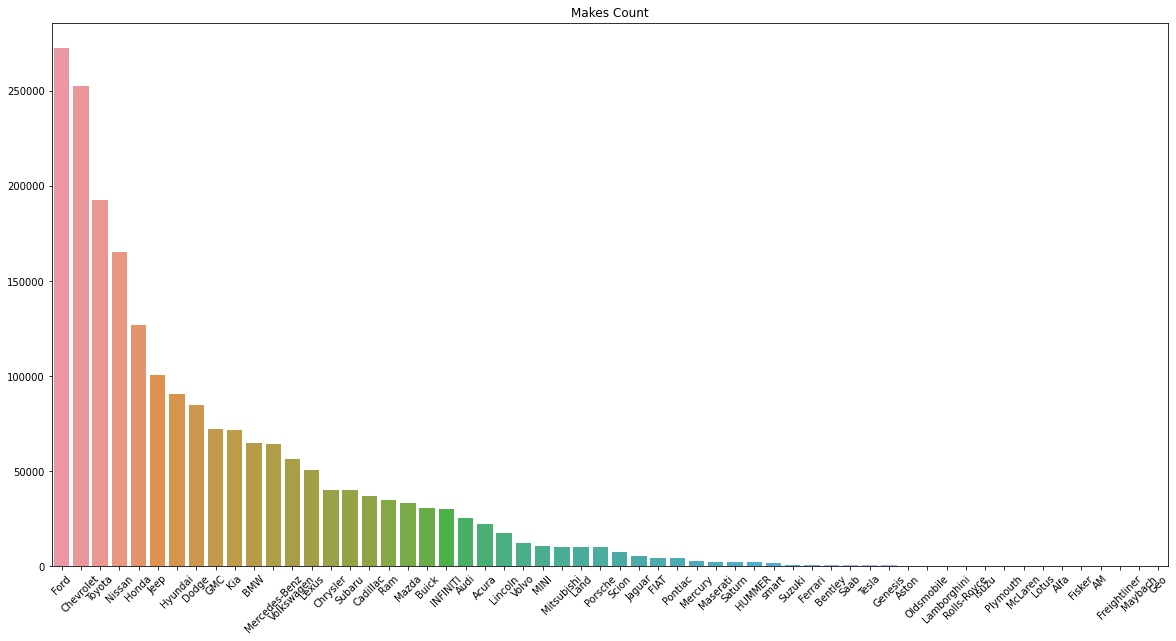

In [111]:
plt.figure(figsize = (20, 10))
plt.title("Makes Count")
ax = sns.barplot(df["Make"].value_counts().index, df["Make"].value_counts().values)
t = plt.xticks(rotation=45)

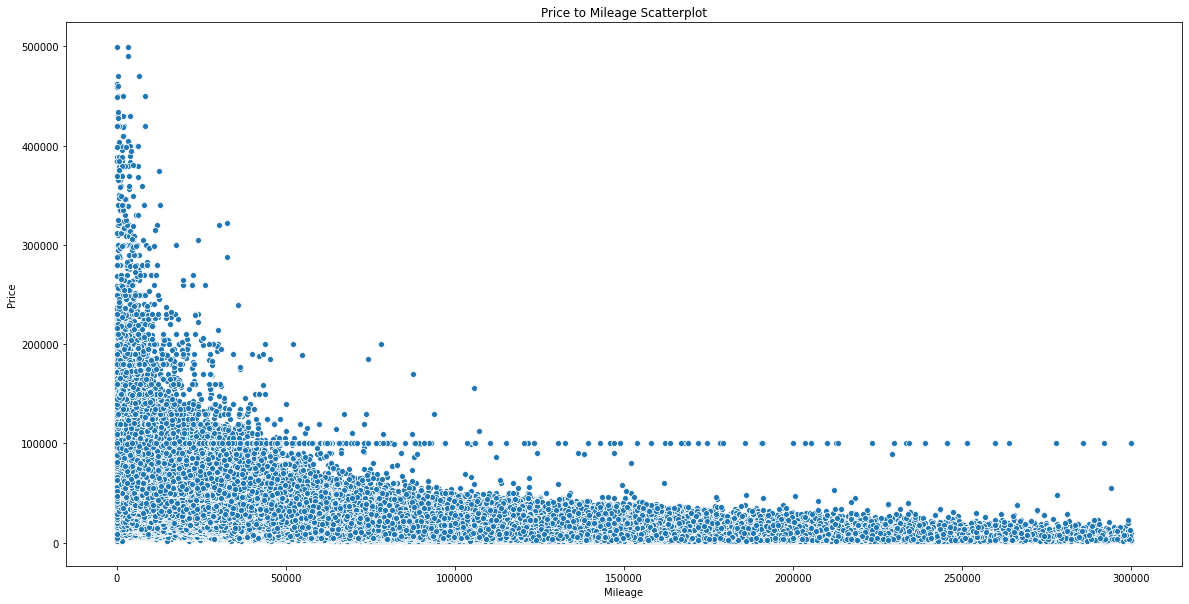

In [112]:
plt.figure(figsize= (20,10))
plt.title("Price to Mileage Scatterplot")
ax = sns.scatterplot(df["Mileage"], df["Price"])

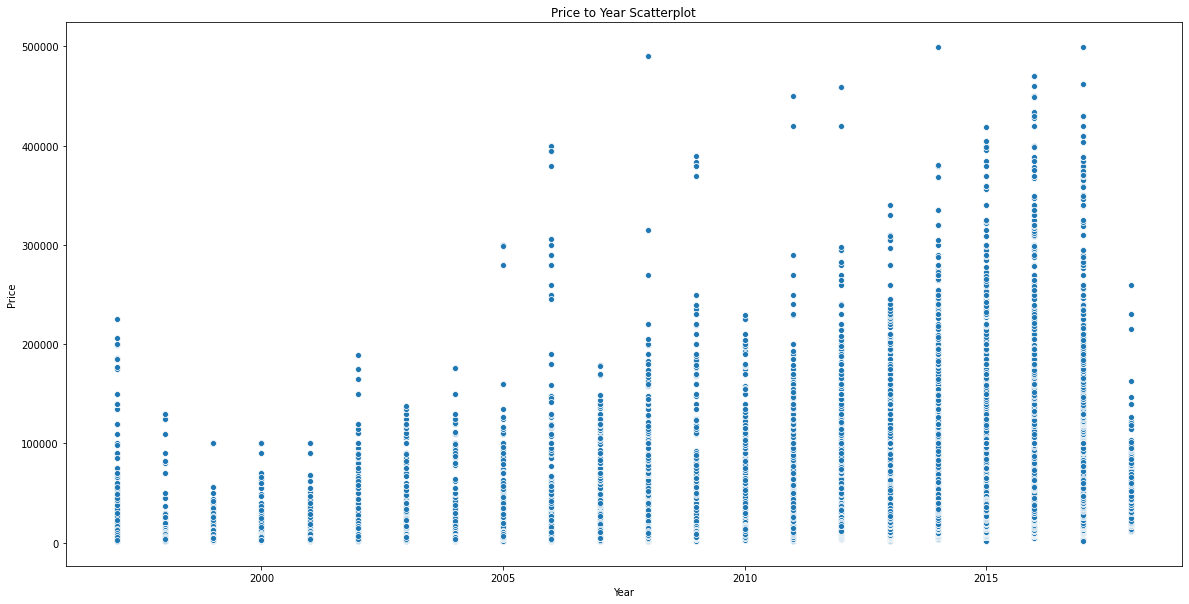

In [113]:
plt.figure(figsize= (20,10))
plt.title("Price to Year Scatterplot")
ax = sns.scatterplot(df["Year"], df["Price"])

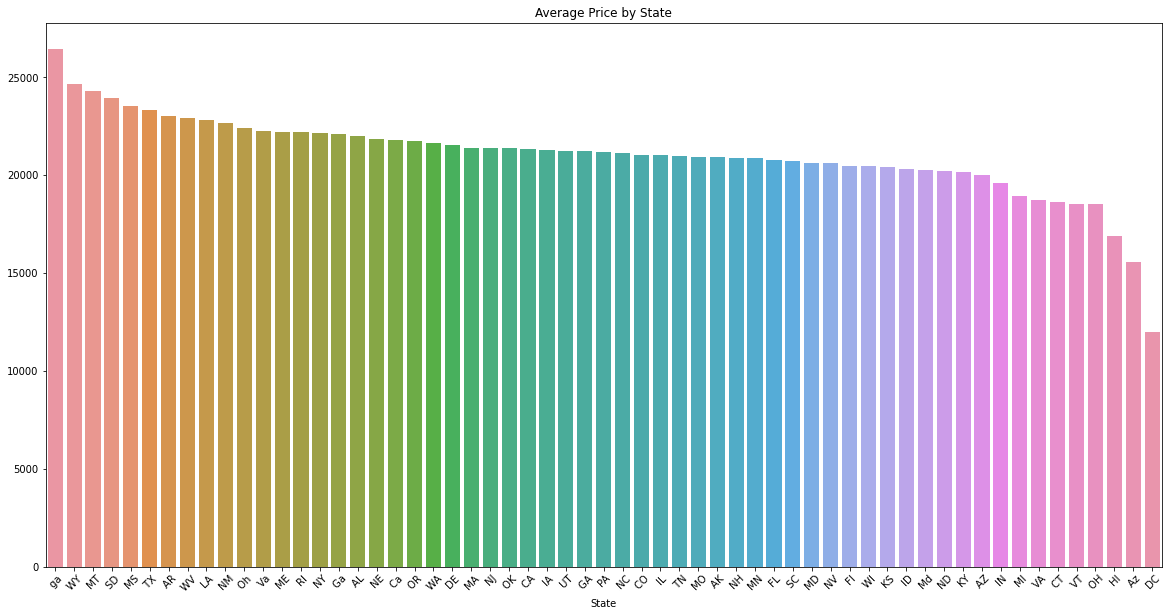

In [114]:
plt.figure(figsize=(20,10))
plt.title("Average Price by State")
ax = sns.barplot(df.groupby("State").Price.mean().sort_values(ascending=False).index, df.groupby("State").Price.mean().sort_values(ascending=False).values)
t = plt.xticks(rotation=45)

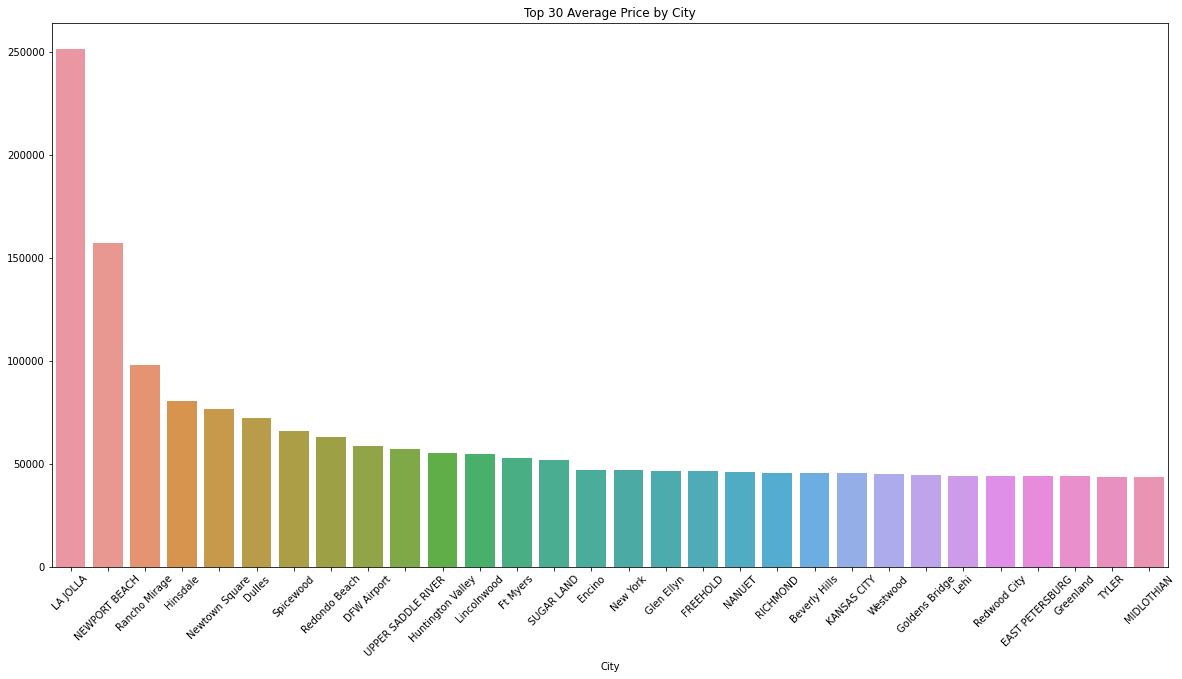

In [115]:
plt.figure(figsize=(20,10))
plt.title("Top 30 Average Price by City")
ax = sns.barplot(df.groupby("City").Price.mean().sort_values(ascending=False)[:30].index, df.groupby("City").Price.mean().sort_values(ascending=False)[:30].values)
t = plt.xticks(rotation=45)

# Baseline Model

## Label Processing

In [130]:
le = LabelEncoder()
df[["State", "Make", "City", "Model"]] = df[["State", "Make", "City", "Model"]].apply(le.fit_transform)

## Train-test split

In [144]:
X = df[["Year", "Mileage", "City", "State", "Make", "Model"]]
y = df[["Price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

## Scaling

In [147]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Random Forest Model

In [149]:
rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

<ipython-input-149-6313e855a7cd>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


In [153]:
print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 13416.41
Mean Squared Error: 316087637.98
Root Mean Squared Error: 17778.85


In [157]:
importances= list(rf.feature_importances_)
features = ["Year", "Mileage", "City", "State", "Make", "Model"]
feature_importance = {}
for i in range(len(features)):
    feature_importance[features[i]] = importances[i]
feature_importance

{'Year': 0.08321105457141423,
 'Mileage': 0.2574826404244845,
 'City': 0.029404997372408835,
 'State': 0.017739932436726894,
 'Make': 0.24439515507357096,
 'Model': 0.36776622012139465}

## XGBoost Model